<a href="https://colab.research.google.com/github/Icepeak01/FAKE-NEWS-CLASSIFIER-USING-LSTM-Biderectional-RNN-/blob/main/Fake_News_Classifier_Using_LSTM_%26_Bidirectional_LSTM_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
from sklearn.pipeline import  Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/fake-news/train.csv')

In [4]:
df.head(4)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1


In [5]:
df = df.drop(["title", "author", "id"], axis=1)

In [6]:
df.isnull().sum()

,0
text,39
label,0


In [7]:
# Drop Nan Values
df = df.dropna()

<Axes: xlabel='label', ylabel='count'>

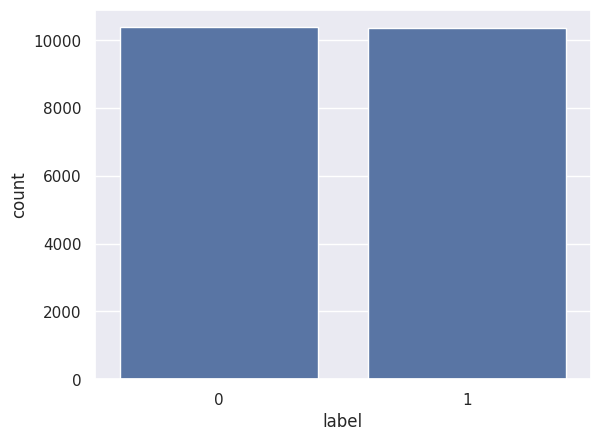

In [8]:
sns.countplot(data = df, x='label')

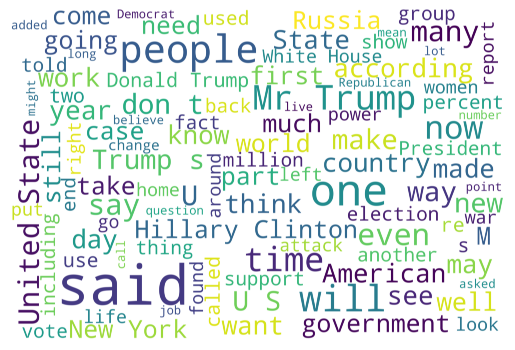

In [9]:
word_cloud_text = ''.join(df['text'])

wordcloud = WordCloud(max_font_size=100,
                      max_words=100,
                      background_color="white",
                      scale = 10,
                      width=900,
                      height=600
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,
           interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
# Get the Independent Features
X = df.drop('label',axis=1)

In [11]:
# Get the Dependent features
y = df['label']

In [12]:
messages=X.copy()

In [13]:
messages['text'][1]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

In [14]:
messages.reset_index(inplace=True)

In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   20761 non-null  int64 
 1   text    20761 non-null  object
dtypes: int64(1), object(1)
memory usage: 324.5+ KB


### CREATING A DEF FUNCTION FOR PREPROCESSING THE TEXTS

In [16]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def process_text_and_encode(texts, voc_size=5000, sent_length=20, lower=True, remove_special_chars=True, remove_stopwords=True, lemmatize=True):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_texts = []

    for text in texts:
        if lower:
            text = text.lower()
        if remove_special_chars:
            text = re.sub(r'[^a-zA-Z\s]', '', text)

        words = nltk.word_tokenize(text)
        if remove_stopwords:
            words = [word for word in words if word not in stop_words]
        if lemmatize:
            words = [lemmatizer.lemmatize(word) for word in words]

        processed_text = ' '.join(words)
        processed_texts.append(processed_text)

    onehot_repr = [one_hot(text, voc_size) for text in processed_texts]
    embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)

    return np.array(embedded_docs)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
texts = messages['text'].tolist()
corpus = process_text_and_encode(texts)
corpus

array([[4378,  927, 3290, ..., 3890, 2050, 4134],
       [2129, 2135, 3928, ..., 2254, 1213, 2645],
       [1504, 4357, 3182, ...,  403, 1371,  150],
       ...,
       [2301,  384,  887, ..., 3790, 1748, 3933],
       [1568, 3430, 3363, ..., 1045,  428, 2111],
       [4123, 3294, 1341, ..., 1618,   24, 2428]], dtype=int32)

In [18]:
print("Processed and Encoded Texts Shape:", corpus.shape)

Processed and Encoded Texts Shape: (20761, 20)


In [19]:
X_final = np.array(corpus)
y_final = np.array(y)

In [20]:
X_final.shape,y_final.shape

((20761, 20), (20761,))

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.30, random_state=42)

## ***USING LSTM***

In [22]:
voc_size = 5000
sent_length = 20

## Creating model
embedding_vector_features=40
lstm = Sequential()
lstm.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
lstm.add(LSTM(100))
lstm.add(Dropout(0.3))
lstm.add(Dense(1,activation='sigmoid'))
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm.build(input_shape=(None, sent_length))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.001, verbose=1)
print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          56,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,501 (1001.96 KB)

 Trainable params: 256,501 (1001.96 KB)

 Non-trainable params: 0 (0.00 B)

None


### Model Training

In [40]:
#Training
lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=12,batch_size=64,callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/12
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0071
Epoch 1: val_accuracy did not improve from 0.84685
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.8212 - val_loss: 1.2833 - learning_rate: 0.0010
Epoch 2/12
225/228 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9973 - loss: 0.0073
Epoch 2: val_accuracy did not improve from 0.84685
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9973 - loss: 0.0073 - val_accuracy: 0.8192 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 3/12
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0070
Epoch 3: val_accuracy did not improve from 0.84685
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.8192 - val_loss: 1.3216 - learning_rate: 0.0010
Epoch 4/12
222/228 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0043
Epoch 4: val_accuracy did not improve from 0.84685
228/228 ━━━━━━━━━━━━━━━━━━━━

### Performance Metrics And Accuracy

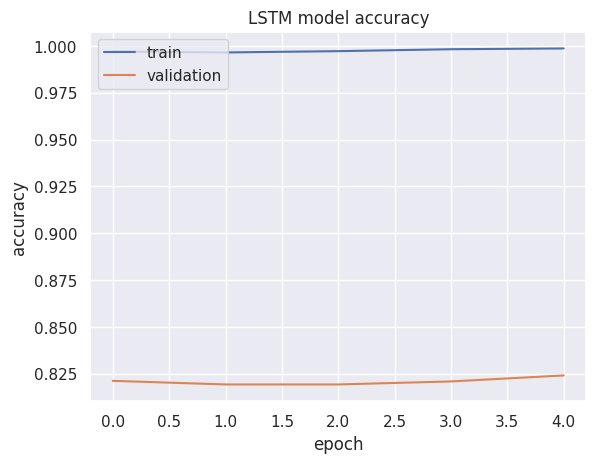

In [41]:
history = lstm.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [42]:
lstm_pred=lstm.predict(X_test)
lstm_pred=np.where(lstm_pred > 0.49, 1, 0)

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [43]:
confusion_matrix(y_test,lstm_pred)

array([[2584,  554],
       [ 562, 2529]])

In [44]:
print(classification_report(y_test,lstm_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3138
           1       0.82      0.82      0.82      3091

    accuracy                           0.82      6229
   macro avg       0.82      0.82      0.82      6229
weighted avg       0.82      0.82      0.82      6229



### ***USING BIDIRECTIONAL LSTM***

In [45]:
embedding_vector_features=40
BDR = Sequential()
BDR.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
BDR.add(Bidirectional(LSTM(100)))
BDR.add(Dropout(0.3))
BDR.add(Dense(1,activation='sigmoid'))
BDR.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
BDR.build(input_shape=(None, sent_length))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_bdr_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.001, verbose=1)
print(BDR.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 20, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 313,001 (1.19 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
BDR.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=12,batch_size=64,callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/12
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7410 - loss: 0.4889
Epoch 1: val_accuracy improved from -inf to 0.84941, saving model to best_bdr_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7419 - loss: 0.4877 - val_accuracy: 0.8494 - val_loss: 0.3297 - learning_rate: 0.0010
Epoch 2/12
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9033 - loss: 0.2491
Epoch 2: val_accuracy did not improve from 0.84941
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9033 - loss: 0.2491 - val_accuracy: 0.8493 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 3/12
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9396 - loss: 0.1607
Epoch 3: val_accuracy did not improve from 0.84941
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9395 - loss: 0.1610 - val_accuracy: 0.8385 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 4/12
223/228 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9618 - loss: 0.1149
Epoch 4: val_accuracy did not impro

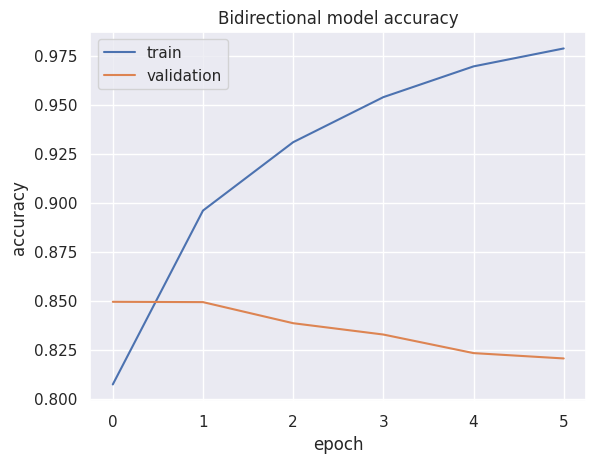

In [47]:
history = BDR.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Bidirectional model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [48]:
bdr_pred= BDR.predict(X_test)
bdr_pred = np.where(lstm_pred > 0.49, 1, 0)

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [49]:
confusion_matrix(y_test,bdr_pred)
print(classification_report(y_test,bdr_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3138
           1       0.82      0.82      0.82      3091

    accuracy                           0.82      6229
   macro avg       0.82      0.82      0.82      6229
weighted avg       0.82      0.82      0.82      6229

